## Objective: To compare the Solved and Predicted structures of therapeutic Abs. 

Ha wanted to see how the methods compare. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm 

from abnumber import Chain as AbChain
from Bio.PDB.Superimposer import Superimposer
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import PDBIO
from Bio.SeqUtils import seq3, seq1

import warnings
warnings.filterwarnings("ignore")

from developability.utils import ls, extract_sequence_from_pdb, determine_chain_type
from developability.pdb_tools import extract_fv_from_pdb, fix_antibody

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

In [2]:
def get_atoms(structure, start=1, end = 100, atom_type='CA'): 
    """ get the atoms from a PDB structure. 
    Args: 
        structure (PDB structure):
    Returns:
        list: list of atoms
    """
    
    atom_list = []
    for model in structure: 
        for chain in model: 
            for residue in chain: 
                res_num = residue.get_id()[1]
                if start<=res_num<=end:
                    atom_list.append(residue[atom_type])
    return atom_list


def get_atom_coords(atom_list): 
    """ get the coordinates from a list of atoms.
    Args:
        atom_list (list): list of atoms
    Returns:
        np.array: array of coordinates
    """
    return np.vstack([atom.get_coord() for atom in atom_list])


def align_antibodies(ab1, ab2, end=100, start=0):
  """Align antibodies using SVD.

    Args:
        ab1 (str|Path): path to first antibody. This is the template. 
        ab2 (str|Path): path to second antibody. This is aligned to the template. 
        output_path (str|Path, optional): _description_. Defaults to None.
        end (int, optional): position to end alignment. Defaults to 100. 
        start (int, optional): position to start alignment. Defaults to 0.
    Returns: 
      list[Structure]: list of structures for ab1 and ab2
      
    """
  parser = PDBParser()
  structure1 = parser.get_structure('ab1', ab1)
  structure2 = parser.get_structure('ab2', ab2)

  atom_list1 = get_atoms(structure1,start=start,end=end)
  atom_list2 = get_atoms(structure2,start=start,end=end)

  print(f'Intial RMS is {compute_rms_between_atom_list(atom_list1, atom_list2)}')

  super_imposer =Superimposer()
  super_imposer.set_atoms(atom_list1, atom_list2)
  super_imposer.apply(structure2.get_atoms())

  print(f'Final RMS is {compute_rms_between_atom_list(atom_list1, atom_list2)}')

  return [structure1, structure2]


def compute_rms(coords1, coords2):
    """Compute the RMS between two sets of coordinates.
    Args: 
        coords1 (np.array): coordinates
        coords2 (np.array): coordinates
    Returns:
        float: RMS
    """
    return np.sqrt(np.mean(np.sum(np.square(coords1 - coords2), axis=1)))


def compute_rms_between_atom_list(atom_list1, atom_list2):
    """Compute the RMS between two lists of atoms. 
    Args: 
        atom_list1 (list): list of atoms
        atom_list2 (list): list of atoms
    Returns: 
        float: RMS
    """
    atom_coords1 = get_atom_coords(atom_list1)
    atom_coords2 = get_atom_coords(atom_list2)
    return compute_rms(atom_coords1, atom_coords2)


def compute_rms_between_structures(structure1, structure2, end = 120, start = 0):
    """Compute the RMS between two structures. 
    Args: 
        structure1 (PDB structure): structure
        structure2 (PDB structure): structure
    Returns: 
        float: RMS
    """
    atom_list1 = get_atoms(structure1, start=start, end=end)
    atom_list2 = get_atoms(structure2, start=start, end=end)

    return compute_rms_between_atom_list(atom_list1, atom_list2)



def parse_region_key_value(key_value, number):
    """Parse the region key_value into a tuple of (chain, id). 
    Args: 
        key_value (tuple(str)): key, value from region dict
        number (int): number of the residue in raw sequence 
    Returns: 
        tuple: (chain, id, 3 Letter Code of residue)
    """
    key, value = key_value
    
    chain = key.chain_type
    id = number

    return chain, id, seq3(value).upper()


def parse_chain_regions(chain):
    """Parse the regions from a abnumber chain object in 

    Args:
        chain (AbChain): an antibody chain
    Returns: 
        dict: dictionary of regions
    """
    regions = {}
    i = 1
    for name, region in chain.regions.items():
        positions = []
        for value in region.values():
            if chain.is_light_chain():
                chain_name = 'L'
            else:
                chain_name = 'H'

            positions.append((chain_name, i, seq3(value).upper()))
            i+=1
        regions[name] = set(positions)
    return regions


def generate_residue_tuple(residue):
    """Given a residue, generates a tuple of (chain, id, 3 Letter Code of residue)

    Args:
        residue (Bio.PDB.Residue.Residue): a residue container
    Returns: 
        tuple: (chain, id, 3 Letter Code of residue)
    """
    return residue.parent.id, residue.id[1], residue.get_resname()


def get_atoms_from_fv_region(region_set, structure, chain_name, atom_type='CA', model=0):
    """Get the atoms from a FV region in a structure.
    Args:
        region (set(tuples)): _description_
        structure (_type_): _description_
        chain_name (str): _description_
        atom_type (str, optional): _description_. Defaults to 'CA'.
    Returns:

    """
    
    chain = structure[model][chain_name]
    atoms = [residue[atom_type] for residue in chain.get_residues() if generate_residue_tuple(residue) in region_set]
    return atoms


def compute_rms_between_antibody_fv_regions(pdb1, pdb2,end=120, scheme='kabat'):
    """Compute the RMS between two antibodies by fv region

    Args:
        pdb1 (Path|str): path to pdb for ab 1
        pdb2 (Path|str): path to pdb for ab 2
    Returns: 
        pd.DataFrame: dataframe of RMS values
    """

    struct1, struct2 = align_antibodies(pdb1, pdb2, end=end, start=0)

    seqs1 = extract_sequence_from_pdb(struct1)
    seqs2 = extract_sequence_from_pdb(struct2)

    rms_list = []

    for chain_name in [ 'H', 'L']:
        chain1 = AbChain(seqs1[chain_name], scheme=scheme)
        chain2 = AbChain(seqs2[chain_name], scheme = scheme)
        

        regions1 = parse_chain_regions(chain1)
        regions2 = parse_chain_regions(chain2)

        for region_name in regions1: 
            atom_list1 = get_atoms_from_fv_region(regions1[region_name], struct1, chain_name)
            atom_list2 = get_atoms_from_fv_region(regions2[region_name], struct2, chain_name)

            if atom_list1 and atom_list2:
                rms = compute_rms_between_atom_list(atom_list1, atom_list2)
                rms_list.append([f'{chain_name}-{region_name}', rms, len(atom_list1)])
    
    rms_df = (pd.DataFrame(rms_list, columns=['region', 'rms', 'num_atoms'])
              .set_index('region')
              )
    rms_df.loc['Total'] = [compute_rms_between_structures(struct1, struct2, end=end, start=0), np.nan]
    return rms_df



In [3]:
data_path = Path("/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies")
downloaded_pdbs = data_path/'fv_only_pbds'
abs = [f for f in ls(downloaded_pdbs) if f.name.endswith('.pdb')]

ab1 = abs[0]
ab2 = abs[1]

res = compute_rms_between_antibody_fv_regions(ab1,ab1)



Intial RMS is 0.0
Final RMS is 0.0


In [4]:
fv_path = data_path/'fv_only_pbds'
predicted_pdbs = data_path/'renumbered_abs'
abs = [f.name.split('_')[0] for f in ls(fv_path) if f.name.endswith('.pdb')]


def get_ab_file(ab): 
    return ([f for f in ls(fv_path) if f.name.startswith(ab) and f.name.endswith('.pdb')][0], 
            [f for f in ls(predicted_pdbs) if f.name.startswith(ab) and f.name.endswith('.pdb') ][0]
            )

In [5]:
rms = []
number_atoms = []
for ab in tqdm(abs, total = len(abs)):
    ab1, ab2 = get_ab_file(ab)
    try:
        res = compute_rms_between_antibody_fv_regions(ab1,ab2)
        r = res[['rms']].T
        r.index = [ab]
        number = res[['num_atoms']].T
        number.index = [ab]

        rms.append(r)
        number_atoms.append(number)

    except:
        pass
    
rms_df = pd.concat(rms)
number_df = pd.concat(number_atoms)

  0%|          | 0/52 [00:00<?, ?it/s]

Intial RMS is 48.18301010131836
Final RMS is 0.3912836015224457
Intial RMS is 61.078895568847656
Final RMS is 1.007403016090393
Intial RMS is 43.00745391845703
Final RMS is 0.34818193316459656
Intial RMS is 39.53690719604492
Final RMS is 0.332152783870697
Intial RMS is 44.951416015625
Final RMS is 0.563205897808075
Intial RMS is 64.4574966430664
Final RMS is 0.3558984100818634
Intial RMS is 99.26952362060547
Final RMS is 0.40683820843696594
Intial RMS is 119.21214294433594
Final RMS is 0.3300899267196655
Intial RMS is 69.24856567382812
Final RMS is 0.49279797077178955
Intial RMS is 35.157833099365234
Final RMS is 0.5615896582603455
Intial RMS is 92.7261734008789
Final RMS is 0.37869617342948914
Intial RMS is 50.25523376464844
Final RMS is 0.7776283025741577
Intial RMS is 35.061363220214844
Final RMS is 0.4149472713470459
Intial RMS is 51.175018310546875
Final RMS is 0.7665355205535889
Intial RMS is 60.03227615356445
Final RMS is 0.5729117393493652
Intial RMS is 79.23129272460938
Final 

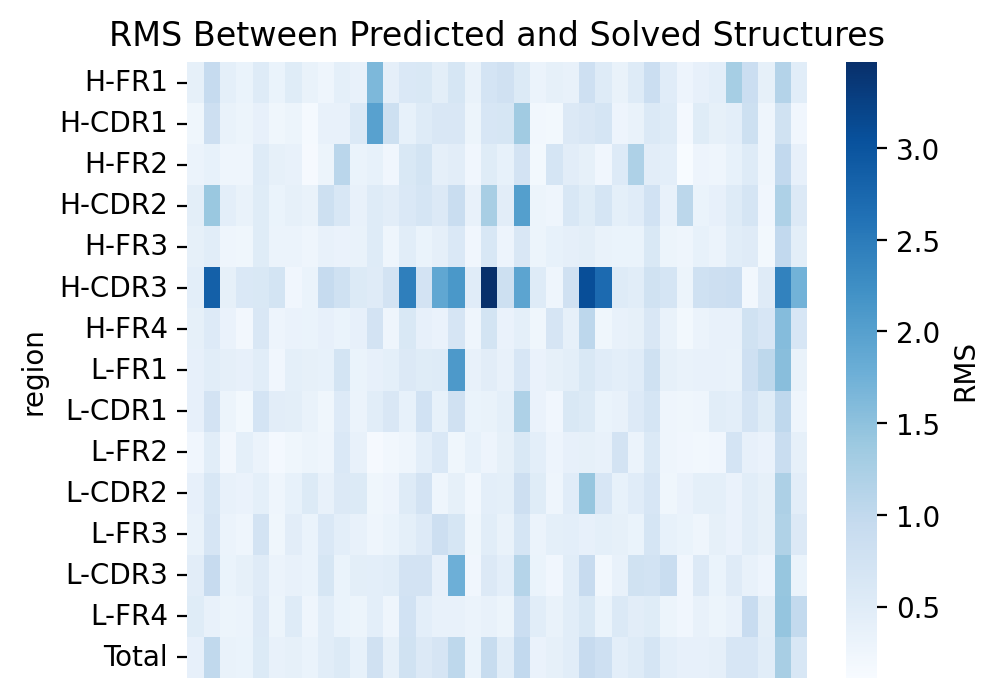

In [6]:
rms_df = np.round(rms_df,2)
fig, axes = plt.subplots(1,1, figsize=(5, 4))

ax= sns.heatmap(rms_df.T, annot=False, cmap='Blues', ax=axes, cbar_kws={'label': 'RMS'})
ax.set(xticklabels="", xticks=[], title='RMS Between Predicted and Solved Structures');


In [7]:
np.round(pd.DataFrame(rms_df.median()).T,3)

region,H-FR1,H-CDR1,H-FR2,H-CDR2,H-FR3,H-CDR3,H-FR4,L-FR1,L-CDR1,L-FR2,L-CDR2,L-FR3,L-CDR3,L-FR4,Total
0,0.47,0.425,0.385,0.51,0.36,0.735,0.39,0.43,0.44,0.35,0.43,0.405,0.455,0.37,0.49


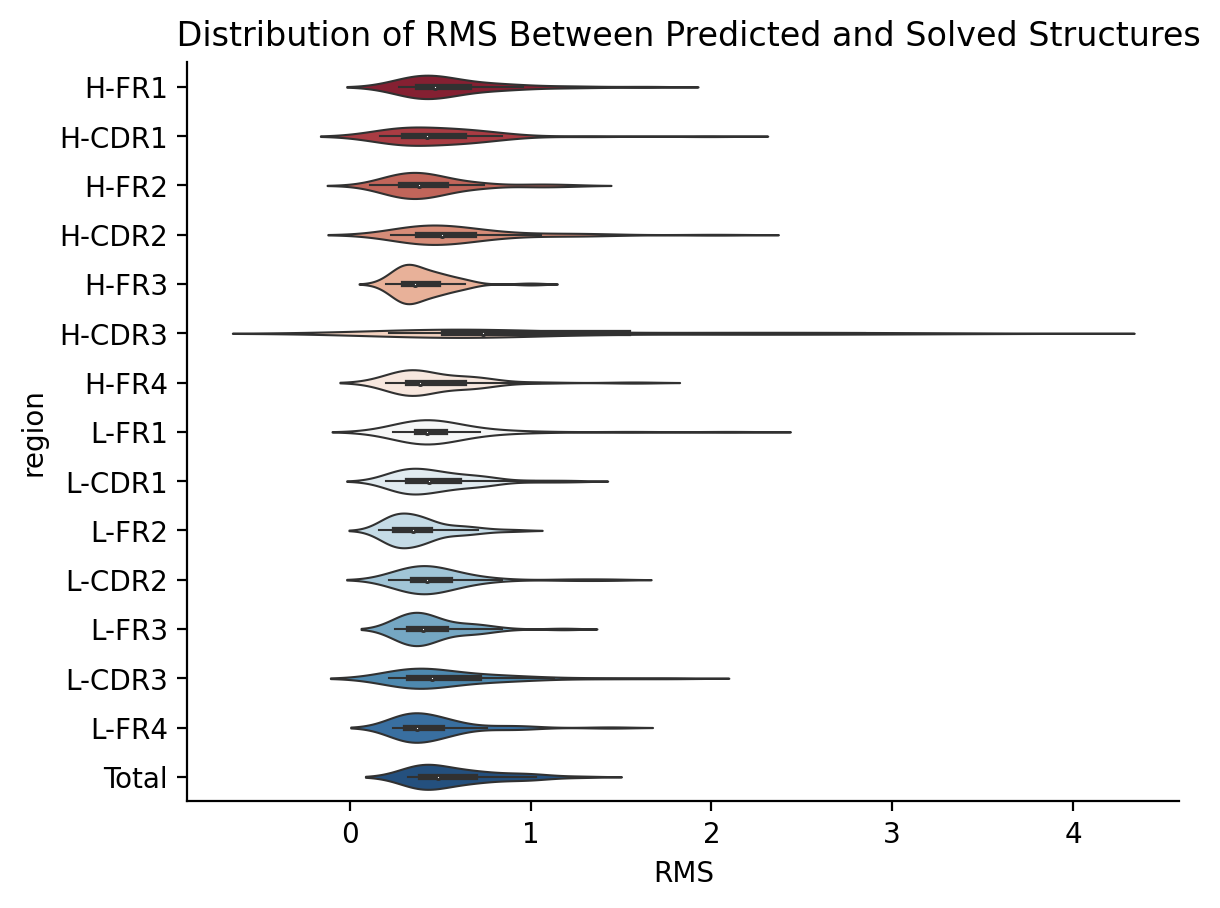

In [8]:
ax = sns.violinplot(data =rms_df, orient='h', palette ='RdBu', linewidth=0.75, alpha = 0.5)
ax.set(xlabel='RMS',title=' Distribution of RMS Between Predicted and Solved Structures')
sns.despine()

### Remarks: 

Above I wrote code to do comparisions of inidivudal regions of antibody. 
IT first aligns the overall structures and then calculates RMS per region. 
We see good aggreement between the structures with the exception of HCDR3. 